**Testing the network**

In [1]:
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt

from img_helper import channel_extractor_c1, channel_reducer_cv, v_channel_upd, rgb_to_hsv_images, hsv_to_rgb_images, plotting_func

from tensorflow.keras.models import load_model

# Fix random seed for reproducibility
seed = 20
np.random.seed(seed)

In [2]:
dataset_npy_path="Dataset npys/"
saved_figs_path = "Results/"
trained_models_path = "trained models/"

**Loading models**

In [3]:
# load models

stack_encoder = load_model(os.path.join(trained_models_path,'stack_encoder_100.h5'))

conv_encoder = load_model(os.path.join(trained_models_path,'c_e.h5'))

# summarize model.

stack_encoder.summary()

conv_encoder.summary()

#load training history

with open('trainHistoryDict_stack.pkl',"rb") as f:
    history_stack = pickle.load(f)

with open('trainHistoryDict_conv.pkl',"rb") as f:
    history_conv = pickle.load(f)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100)          0         
_________________________________________________________________
dense (Dense)                (None, 100, 100)          10100     
Total params: 10,100
Trainable params: 10,100
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d

**Loading data**

In [4]:

#load data

training_RGB_Low = np.load(os.path.join(dataset_npy_path,"training_RGB_Low.npy"))
testing_RGB_Low = np.load(os.path.join(dataset_npy_path,"testing_RGB_Low.npy"))
training_HSV_Low = np.load(os.path.join(dataset_npy_path,"training_HSV_Low.npy"))
training_HSV_High = np.load(os.path.join(dataset_npy_path,"training_HSV_High.npy"))
training_HSV_High_noisy = np.load(os.path.join(dataset_npy_path,"training_HSV_High_noisy.npy"))
testing_HSV_Low = np.load(os.path.join(dataset_npy_path,"testing_HSV_Low.npy"))
print("data loaded")

data loaded


**Testing the dual auto encoder network**

In [5]:
# Image parameters
image_width = 100
image_height = image_width
no_of_channels = 3

**Modify training images for channel visualization**

In [6]:
training_value_Low = channel_reducer_cv(training_HSV_Low)
training_value_High = channel_reducer_cv(training_HSV_High)
training_value_High_noisy = channel_reducer_cv(training_HSV_High_noisy)
training_value_RGB_Low = hsv_to_rgb_images(training_value_Low)#2
training_value_RGB_High = hsv_to_rgb_images(training_value_High)#3
training_value_RGB_High_noisy = hsv_to_rgb_images(training_value_High_noisy)#4

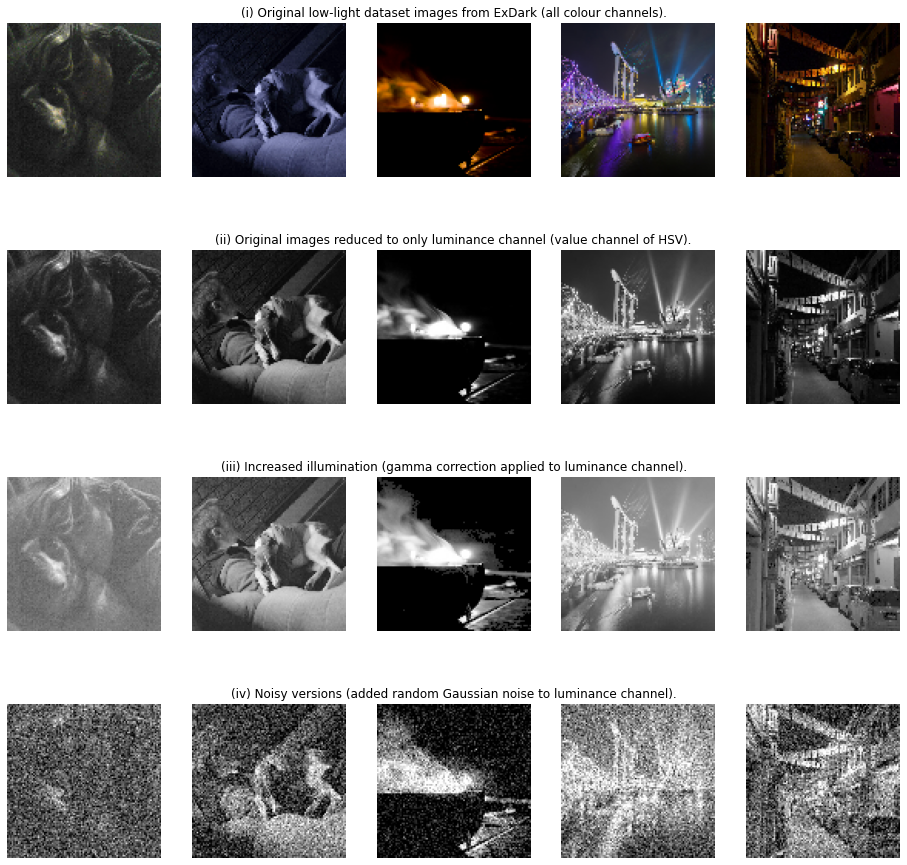

In [7]:
# Create a figure of sample training images 
D = [training_RGB_Low, training_value_RGB_Low, training_value_RGB_High, training_value_RGB_High_noisy]
T = ["(i) Original low-light dataset images from ExDark (all colour channels).",
		"(ii) Original images reduced to only luminance channel (value channel of HSV).",
		"(iii) Increased illumination (gamma correction applied to luminance channel).",
		"(iv) Noisy versions (added random Gaussian noise to luminance channel)."]
fig = plotting_func(4, 5, D, T, 20)
fig.set_size_inches(16, 16)
fig.savefig(os.path.join(saved_figs_path,'training_image_samples.jpg'), dpi=120)
plt.show()

**Plotting metrics**

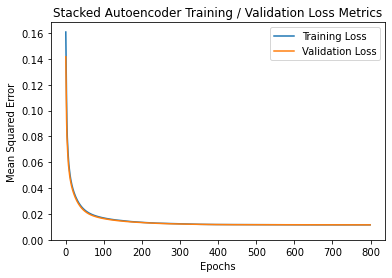

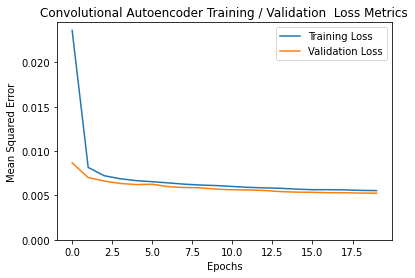

In [8]:
 #Plot stacked encoder metrics
stack_fig = plt.figure()
plt.plot(history_stack['loss'], label='Training Loss')
plt.plot(history_stack['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.ylim([0,max(plt.ylim())])
plt.title('Stacked Autoencoder Training / Validation Loss Metrics')
plt.show()
stack_fig.savefig(os.path.join(saved_figs_path,'stack_training_metrics.jpg'), dpi=120)

# Plot convolutional encoder metrics
conv_fig = plt.figure()
plt.plot(history_conv['loss'], label='Training Loss')
plt.plot(history_conv['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.ylim([0,max(plt.ylim())])
plt.title('Convolutional Autoencoder Training / Validation  Loss Metrics')
plt.show()
conv_fig.savefig(os.path.join(saved_figs_path,'conv_training_metrics.jpg'), dpi=120)

**Testing**

In [9]:
dataset_npy_path = "D:/university/winter 2020/2d image processing/Final Project/2d pro files/PhotoCD_PCD0992 npys/"

testing_RGB_Low_new = np.load(os.path.join(dataset_npy_path,"testing_RGB_Low_new.npy"))
testing_HSV_Low_new = np.load(os.path.join(dataset_npy_path,"testing_HSV_Low_new.npy"))
print("data loaded")

data loaded


In [10]:
# Test dual encoder network
stack_encoder_out_value = stack_encoder.predict(testing_HSV_Low_new[:,:,:,2])
g_by_L = testing_HSV_Low_new[:,:,:,2]/stack_encoder_out_value
stack_encoder_out_HSV = v_channel_upd(testing_HSV_Low_new, stack_encoder_out_value)
con_encoder_out_value = conv_encoder.predict(channel_extractor_c1(stack_encoder_out_HSV, image_width, 2))
con_encoder_out_HSV = v_channel_upd(stack_encoder_out_HSV, con_encoder_out_value[:,:,:,0])

In [11]:
# Modify test images for channel visualization
testing_value_Low = channel_reducer_cv(testing_HSV_Low_new)
testing_value_RGB_Low = hsv_to_rgb_images(testing_value_Low)
stack_encoder_out_value = channel_reducer_cv(stack_encoder_out_HSV)
stack_encoder_out_RGB = hsv_to_rgb_images(stack_encoder_out_HSV)
stack_encoder_out_value_RGB = hsv_to_rgb_images(stack_encoder_out_value)
con_encoder_out_value = channel_reducer_cv(con_encoder_out_HSV)
con_encoder_out_value_RGB = hsv_to_rgb_images(con_encoder_out_value)
con_encoder_out_RGB = hsv_to_rgb_images(con_encoder_out_HSV)

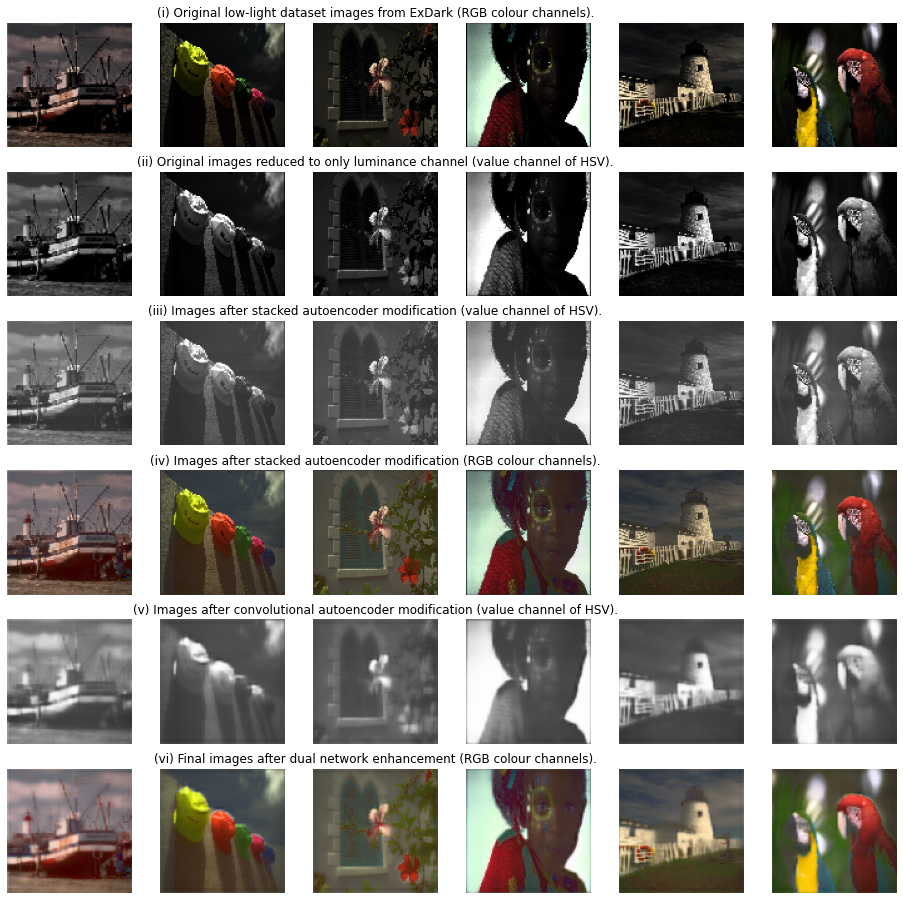

In [12]:
# Create a figure of sample test images
plot_data = [testing_RGB_Low_new, testing_value_RGB_Low, stack_encoder_out_value_RGB, stack_encoder_out_RGB, con_encoder_out_value_RGB, con_encoder_out_RGB]
plot_titles = ["(i) Original low-light dataset images from ExDark (RGB colour channels).",
        "(ii) Original images reduced to only luminance channel (value channel of HSV).",
        "(iii) Images after stacked autoencoder modification (value channel of HSV).",
        "(iv) Images after stacked autoencoder modification (RGB colour channels).",
        "(v) Images after convolutional autoencoder modification (value channel of HSV).",
        "(vi) Final images after dual network enhancement (RGB colour channels)."]
fig = plotting_func(6, 6, plot_data, plot_titles, 10)
fig.set_size_inches(16, 16)
fig.savefig(os.path.join(saved_figs_path,'test_image_samples_new.jpg'), dpi=120)
plt.show()

In [13]:
dataset_npy_path = "D:/university/winter 2020/2d image processing/Final Project/2d pro files/PhotoCD_PCD0992 npys/"
testing_RGB_High_new = np.load(os.path.join(dataset_npy_path,"testing_RGB_High_new.npy"))
testing_HSV_High_new = np.load(os.path.join(dataset_npy_path,"testing_HSV_High_new.npy"))
print("data loaded")

data loaded


In [14]:

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

#Calculating peak_signal_noise_ratio for the test image set above
#Calculating mean structural similarity index for the test image set above

#For Synthesized images

PSNR_vals_synthesized = []
for i in range(len(testing_RGB_High_new)):
    PSNR_vals_synthesized.append(psnr(testing_RGB_High_new[i,:,:,:],testing_RGB_Low_new[i,:,:,:], data_range=1))

print("Synthesized Images PSNR")
print(PSNR_vals_synthesized)
print("\n")

#For Synthesized images

SSIM_vals_synthesized = []
for i in range(len(testing_RGB_High_new)):
    SSIM_vals_synthesized.append(ssim(testing_RGB_High_new[i,:,:,:],testing_RGB_Low_new[i,:,:,:], data_range=1, multichannel=True))

print("Synthesized Images SSIM")
print(SSIM_vals_synthesized)
print("\n")

#For Stack autoencoder output images

PSNR_vals_stack_RGB = []
for i in range(len(testing_RGB_High_new)):
    PSNR_vals_stack_RGB.append(psnr(testing_RGB_High_new[i,:,:,:],stack_encoder_out_RGB[i,:,:,:], data_range=1))

print("Stack autoencoder output images PSNR")
print(PSNR_vals_stack_RGB)
print("\n")

#For Stack autoencoder output images

SSIM_vals_stack_RGB = []
for i in range(len(testing_RGB_High_new)):
    SSIM_vals_stack_RGB.append(ssim(testing_RGB_High_new[i,:,:,:],stack_encoder_out_RGB[i,:,:,:], data_range=1, multichannel=True))

print("Stack autoencoder output images SSIM")
print(SSIM_vals_stack_RGB)
print("\n")

#For convolutional autoencoder output images

PSNR_vals_conv_RGB = []
for i in range(len(testing_RGB_High_new)):
    PSNR_vals_conv_RGB.append(psnr(testing_RGB_High_new[i,:,:,:],con_encoder_out_RGB[i,:,:,:], data_range=1))

print("convolutional autoencoder output images PSNR")
print(PSNR_vals_conv_RGB)
print("\n")

#For convolutional autoencoder output images

SSIM_vals_conv_RGB = []
for i in range(len(testing_RGB_High_new)):
    SSIM_vals_conv_RGB.append(ssim(testing_RGB_High_new[i,:,:,:],con_encoder_out_RGB[i,:,:,:], data_range=1, multichannel=True))

print("convolutional autoencoder output images SSIM")
print(SSIM_vals_conv_RGB)
print("\n")

Synthesized Images PSNR
[10.017195247546312, 10.429954645325367, 9.753116906814107, 13.759360765318702, 10.173562252855003, 11.232446762316178]


Synthesized Images SSIM
[0.5574809867109259, 0.3341725909784256, 0.35202584020880595, 0.42186818620366456, 0.4042567190730537, 0.4142861371139726]


Stack autoencoder output images PSNR
[17.46063013047523, 18.40489702912861, 16.971091489371624, 19.237309371999938, 18.086293646524403, 19.518656543405367]


Stack autoencoder output images SSIM
[0.8684318365818336, 0.8287717340154644, 0.7713230958476588, 0.7749831764733487, 0.8078842196405583, 0.843186105389241]


convolutional autoencoder output images PSNR
[17.138556664810437, 17.930407390682433, 16.14745456041718, 20.242667710647602, 17.206389837845105, 19.60682179732798]


convolutional autoencoder output images SSIM
[0.6989330713975296, 0.6770981368728709, 0.5448582813398349, 0.6919091702359478, 0.6301458435483694, 0.7574925806368743]




In [15]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge
from bokeh.io import export_png

def plot_bar(images,y_ran,ours,authors,labels,titles, colors,fn):

#output_file("dodged_bars.html")

    data = {'images' : images,
            labels[0]   : ours,
            labels[1]   : authors}

    source = ColumnDataSource(data=data)

    p = figure(x_range=images, y_range=(0, y_ran), plot_height=250, title=titles,
               toolbar_location=None, tools="")

    p.vbar(x=dodge('images', -0.25, range=p.x_range), top=labels[0], width=0.2, source=source,
           color=colors[0], legend_label=labels[0])

    p.vbar(x=dodge('images',  0.0,  range=p.x_range), top=labels[1], width=0.2, source=source,
           color=colors[1], legend_label=labels[1])

    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.legend.location = "top_right"
    p.legend.orientation = "horizontal"

    show(p)
    export_png(p, filename=os.path.join(saved_figs_path,fn+".png"))

In [16]:
def compare_metrics(PSNR_1, PSNR_2, SSIM_1, SSIM_2, y_range1,y_range2, img_type1, img_type2, colors):
    images = ["fig 10 (a)","fig 10 (b)","fig 10 (c)","fig 10 (d)","fig 10 (e)","fig 10 (f)"]
    
    PSNR_labels = [img_type1+" ours",img_type2+" authors"]
    PSNR_titles = "PSNR of images "
    
    fn = PSNR_titles+PSNR_labels[0]
    
    plot_bar(images,y_range1,PSNR_1,PSNR_2,PSNR_labels,PSNR_titles, colors,fn)
    
    SSIM_labels = [img_type1+" ours",img_type2+" authors"]
    SSIM_titles = "SSIM of images "
    
    fn = SSIM_titles+SSIM_labels[0]
    
    plot_bar(images,y_range2,SSIM_1,SSIM_2,SSIM_labels,SSIM_titles, colors,fn)

In [17]:
PSNR_synthesized_authors = [11.60, 11.79, 11.14, 14.33, 11.18, 11.99]
SSIM_synthesized_authors = [0.5920, 0.4034, 0.4574, 0.3824, 0.4784, 0.5034]

compare_metrics(PSNR_vals_synthesized, PSNR_synthesized_authors, SSIM_vals_synthesized, SSIM_synthesized_authors, 30,2, "Synthesized", "Synthesized", ["red","gray"])

PSNR_proposed_authors = [17.28, 16.91, 16.78, 17.81, 16.51, 16.81]
SSIM_proposed_authors = [0.7474, 0.6782, 0.7200, 0.6699, 0.6643, 0.7469]

compare_metrics(PSNR_vals_stack_RGB, PSNR_proposed_authors, SSIM_vals_stack_RGB, SSIM_proposed_authors, 30,2, "Proposed Stack RGB", "Proposed", ["orange","black"])

compare_metrics(PSNR_vals_conv_RGB, PSNR_proposed_authors, SSIM_vals_conv_RGB, SSIM_proposed_authors, 30,2, "Proposed Conv RGB", "Proposed", ["blue","brown"])

In [18]:
from tensorflow.keras.preprocessing.image import array_to_img

array_to_img(testing_RGB_High_new[2,:,:,:]).save(os.path.join(saved_figs_path,'high contrast window.png'))
array_to_img(testing_RGB_Low_new[2,:,:,:]).save(os.path.join(saved_figs_path,'Low Light window.png'))

array_to_img(testing_RGB_High_new[5,:,:,:]).save(os.path.join(saved_figs_path,'high contrast parrot.png'))
array_to_img(testing_RGB_Low_new[5,:,:,:]).save(os.path.join(saved_figs_path,'Low Light parrot.png'))

array_to_img(stack_encoder_out_RGB[2,:,:,:]).save(os.path.join(saved_figs_path,'stacked encoder out window.png'))
array_to_img(con_encoder_out_RGB[2,:,:,:]).save(os.path.join(saved_figs_path,'con encoder out window.png'))
array_to_img(stack_encoder_out_RGB[5,:,:,:]).save(os.path.join(saved_figs_path,'stacked encoder out parrot.png'))
array_to_img(con_encoder_out_RGB[5,:,:,:]).save(os.path.join(saved_figs_path,'con encoder out parrot.png'))